   # Validação de Dados Modelados com Observados

Carregar arquivos para comparar dados monitorados com séries modelada (arquivos combine)

In [1]:
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import utm
import seaborn as sns
import datetime as dt
from bisect import bisect_left
import math
%matplotlib inline

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before


## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem o arquivo da estação e nomes de rodadas.

In [2]:
directory = str('E:/Mestrado/1.Resultados/QualidadedoAr/')
wrfdir = str('E:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = 'd04_1km'
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
periodo = ['Verão', 'Inverno']

moded = ['-'] #,'-20I','-20T','-20I-20T']
modnames = ['ED']#, 'ED-20I','ED-20T','ED-20I-20T']
modpt = ['_PT_ED-100I']#,'_PT-20_ED-100I', '_PT_ED-100I-20T', '_PT-20_ED-100I-20T']
modptnames = ['PT_ED-100I']#, 'PT-20_ED-100I','PT_ED-100I-20T','PT-20_ED-100I-20T']
shapes = ['pirashape','RMSP']

spinup = 48
run_len = 24*7
gmt = 3

date_index = 0

In [3]:
#DADOS ESTACAO
estacao     = 'PIRACICABA (A)'
estlat,estlon = utm.to_latlon(easting=227797, northing=7487124, zone_letter='k', zone_number=23)
est = pd.read_csv(directory+'piracicaba.csv', delimiter=';')
#est['Hora'] = est['Hora'].apply(lambda x: '24:00' if x == '24:00:00' else x)
est['Hora'] = est['Hora'].apply(lambda x: dt.timedelta(hours=float(x[:2])))
est['Data'] = est['Data'].apply(lambda x: dt.datetime.strptime(x,'%d/%m/%Y'))
est['Data'] += est['Hora']
est.drop(columns=['Unnamed: 0','Hora','wind_dir','wind_dir_avg','temp','ur','wind_vel'], inplace=True)
est.set_index('Data', inplace=True)

## Abrir arquivos COMBINE ACONC e DEP

In [4]:
aconc = []
for ms, dat in zip(mes,data):
    aconc.append(xr.open_dataset(directory+ms+'.'+grade+moded[0]+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                                    ms+'_'+dat+'.nc'))
for ms, dat in zip(mes,data):
    aconc.append(xr.open_dataset(directory+ms+'.'+grade+modpt[0]+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                                    ms+'_'+dat+'.nc'))

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(LAY=0)

## Abrir arquivo WRF para buscar valores de LAT / LON

In [5]:
nc_wrf=[]
for ms, dat in zip(mes,datawrf):
    nc_wrf.append(Dataset(wrfdir+'arqWRF/'+ms+'/wrf_fnl_pira_pedruzzi2016_nudge_'+
                 ms+'/wrfout_'+grade[:3]+'_2015-'+dat+'_00%3A00%3A00'))
nc_wrf.append(nc_wrf[0])
nc_wrf.append(nc_wrf[1])

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [6]:
for a, w in zip(aconc,nc_wrf):
    # DATAS
    dates = []
    dates = [dt.datetime.strptime(str(a.attrs['SDATE']),'%Y%j')]
    for i in range(1,a.dims['TSTEP']):
        dates.append(dates[0]+dt.timedelta(hours=i))
    
# LATITUDE
# LONGITUDE
    croplat = int((w.dimensions['south_north'].size-a.dims['ROW'])/2)
    croplon = int((w.dimensions['south_north'].size-a.dims['ROW'])/2)
    lats      = w.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
    longs     = w.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# COORDENADAS PARA POSICIONAR ESTACAO
    if (estlat > np.amin(lats) and
        estlat < np.amax(lats) and
        estlon > np.amin(longs)and
        estlon < np.amax(longs)):                
        esty     = lats[:,0].tolist().index(takeClosest(lats[:,0],estlat))     #index Lat da estação no domínio
        estx     = longs[0,:].tolist().index(takeClosest(longs[0,:],estlon))   #index Lat da estação no domínio

# PLOT CORNERS
    llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
    llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
    urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
    urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

    coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=a.dims['ROW'])
    coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=a.dims['COL'])


    a.coords['TSTEP'] = dates
    a.coords['ROW'] = coordlat
    a.coords['COL'] = coordlon
    a.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in a.variables:
        if 'units' in a.variables[var].attrs:
            if a.variables[var].attrs['units'].split() != []:
                a.variables[var].attrs['units'] = a.variables[var].attrs['units'].split()[0]

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(TSTEP=slice(spinup,spinup+run_len))
    aconc[i].coords['TSTEP'] -= pd.Timedelta(gmt,'h')
weekd=[]
for d in aconc[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Weekday')
    else:
        weekd.append('Weekend')

D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


## New AQ PICTURES

In [7]:
## Plotar 4 figuras (ED Verao e Inverno, PT Verao e Inverno)
per = ['Summer','Winter','Summer','Winter']
sim = ['(a) '+modnames[0],'(b) '+modnames[0],'(a) '+modptnames[0],'(b) '+modptnames[0]]

(a) ED


D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anacon

(b) ED


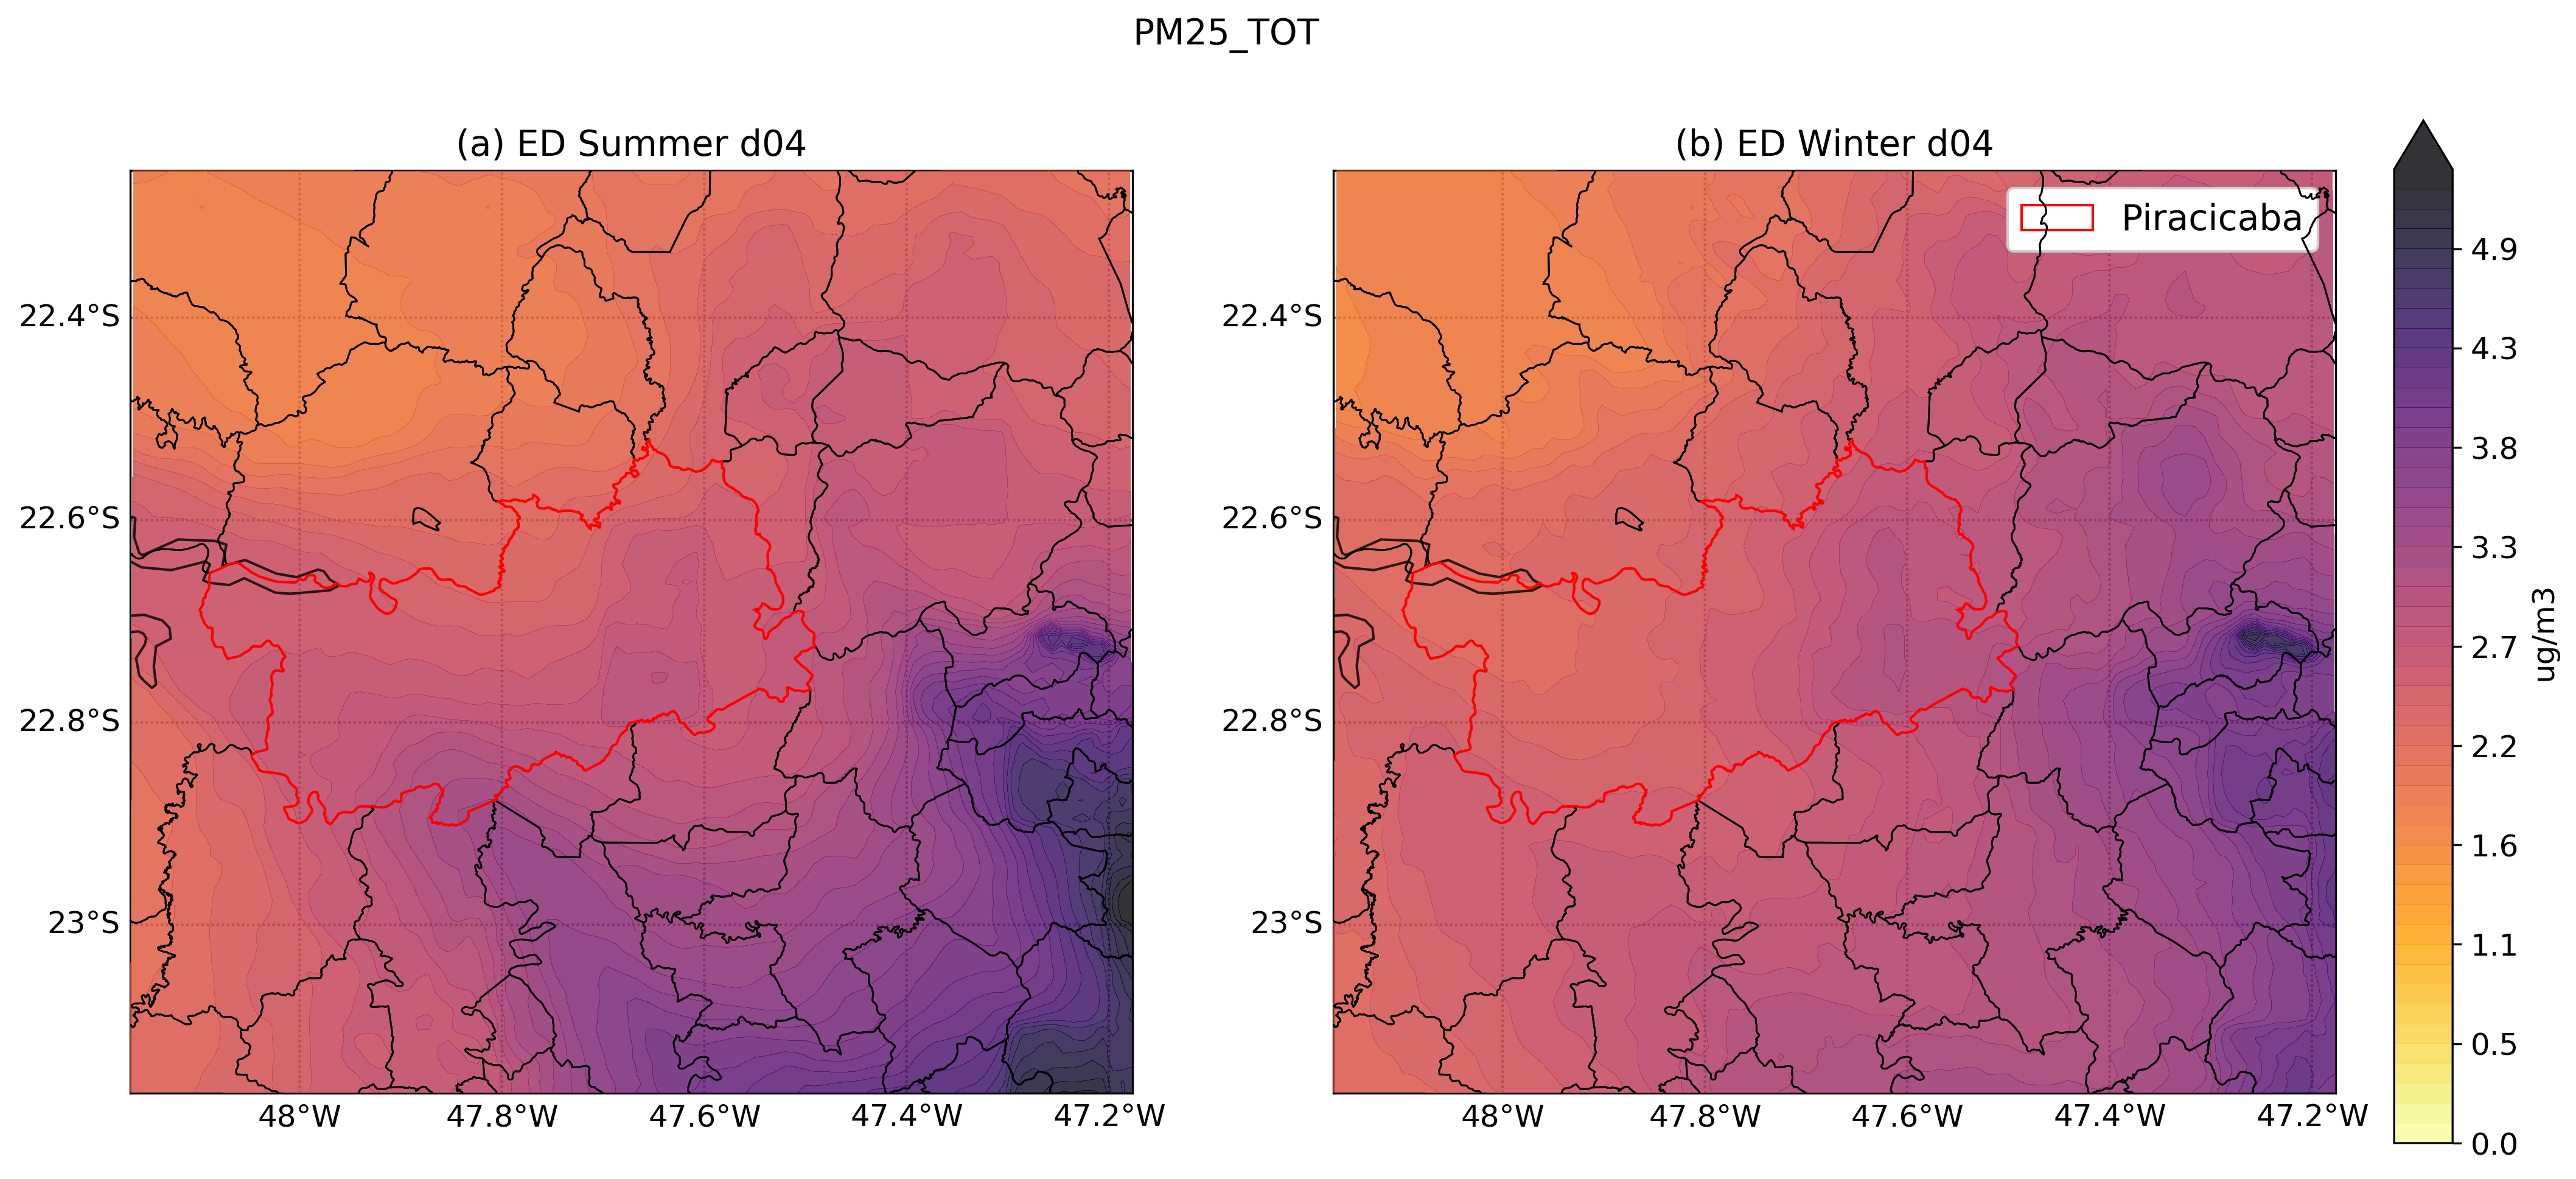

In [8]:
param = 'PM25_TOT'

maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]

aconcsec = aconc[:2]
persec = per[:2]
simsec = sim[:2]

llvl = 0
hlvl = 0
for i in range(0,2):
    if float(aconcsec[i][param].mean(dim='TSTEP').max()) > hlvl:
        hlvl = (float(aconcsec[i][param].mean(dim='TSTEP').max()))
    if float(aconcsec[i][param].mean(dim='TSTEP').min()) < llvl:
        llvl = (float(aconcsec[i][param].mean(dim='TSTEP').min()))

llvl = (np.ceil(llvl*100))/100
hlvl = (np.ceil(hlvl*100))/100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7), dpi=300)
fig.suptitle(param, fontsize=14)

for ac, p, ax, s in zip(aconcsec,persec,axes.flat,simsec):  
    print(s)
    d = np.squeeze(ac[param].mean(dim='TSTEP'))
    d = np.ma.array(d,mask=d<0)

    # PLOT COLORMAP
    ax.set_title(s+' '+p+' '+grade[:3], fontsize=14)
    m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=ax)           
    paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.inferno_r,
                        alpha=0.8,
                        vmin=llvl,
                        vmax=hlvl,
                        levels=np.linspace(llvl,hlvl),
                        extend='max',
                        zorder=5)

# ADD FEATURES
    # Draw some map elements on the map
    m.drawcoastlines(linewidth=1.0, color=[0,0,0,0.8], zorder=8)
    m.drawstates(linewidth=1.0, color='k', zorder=8)
    m.drawcountries(linewidth=1.0, color='k', zorder=8)
    #m.bluemarble()
    #m.shadedrelief()
    #m.drawrivers(color='blue')
    m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
    m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
    #m.arcgisimage(service=maps[6], dpi=500, verbose= True)

# ADD SHAPES
    shps = ['Piracicaba']
    colors= {'Piracicaba':'red', 'RMSP':'purple'}
    shapes = {}
#### SHAPE 1
    m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
    p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
    shapes[shps[0]] = p
    
    m.readshapefile(wrfdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color='k', linewidth=0.7, zorder=9)
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
    for shp in shps:
        ax.add_artist(shapes[shp]) 
## END FOR LOOP


# ADJUST PLOT
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8]) #left, bottom, width, height

#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
axes.flat[1].legend(handles=handles, labels=labels, framealpha=1., loc='upper right', fontsize=14)

## COLORBAR
cbar = fig.colorbar(paramplot, cax=cax, format='%.1f') # Plot Colorbar
cbar.set_label(aconc[0].variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 12)

plt.show()


1394.1676025390625
(a) PT_ED-100I


D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:85: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anacon

(b) PT_ED-100I


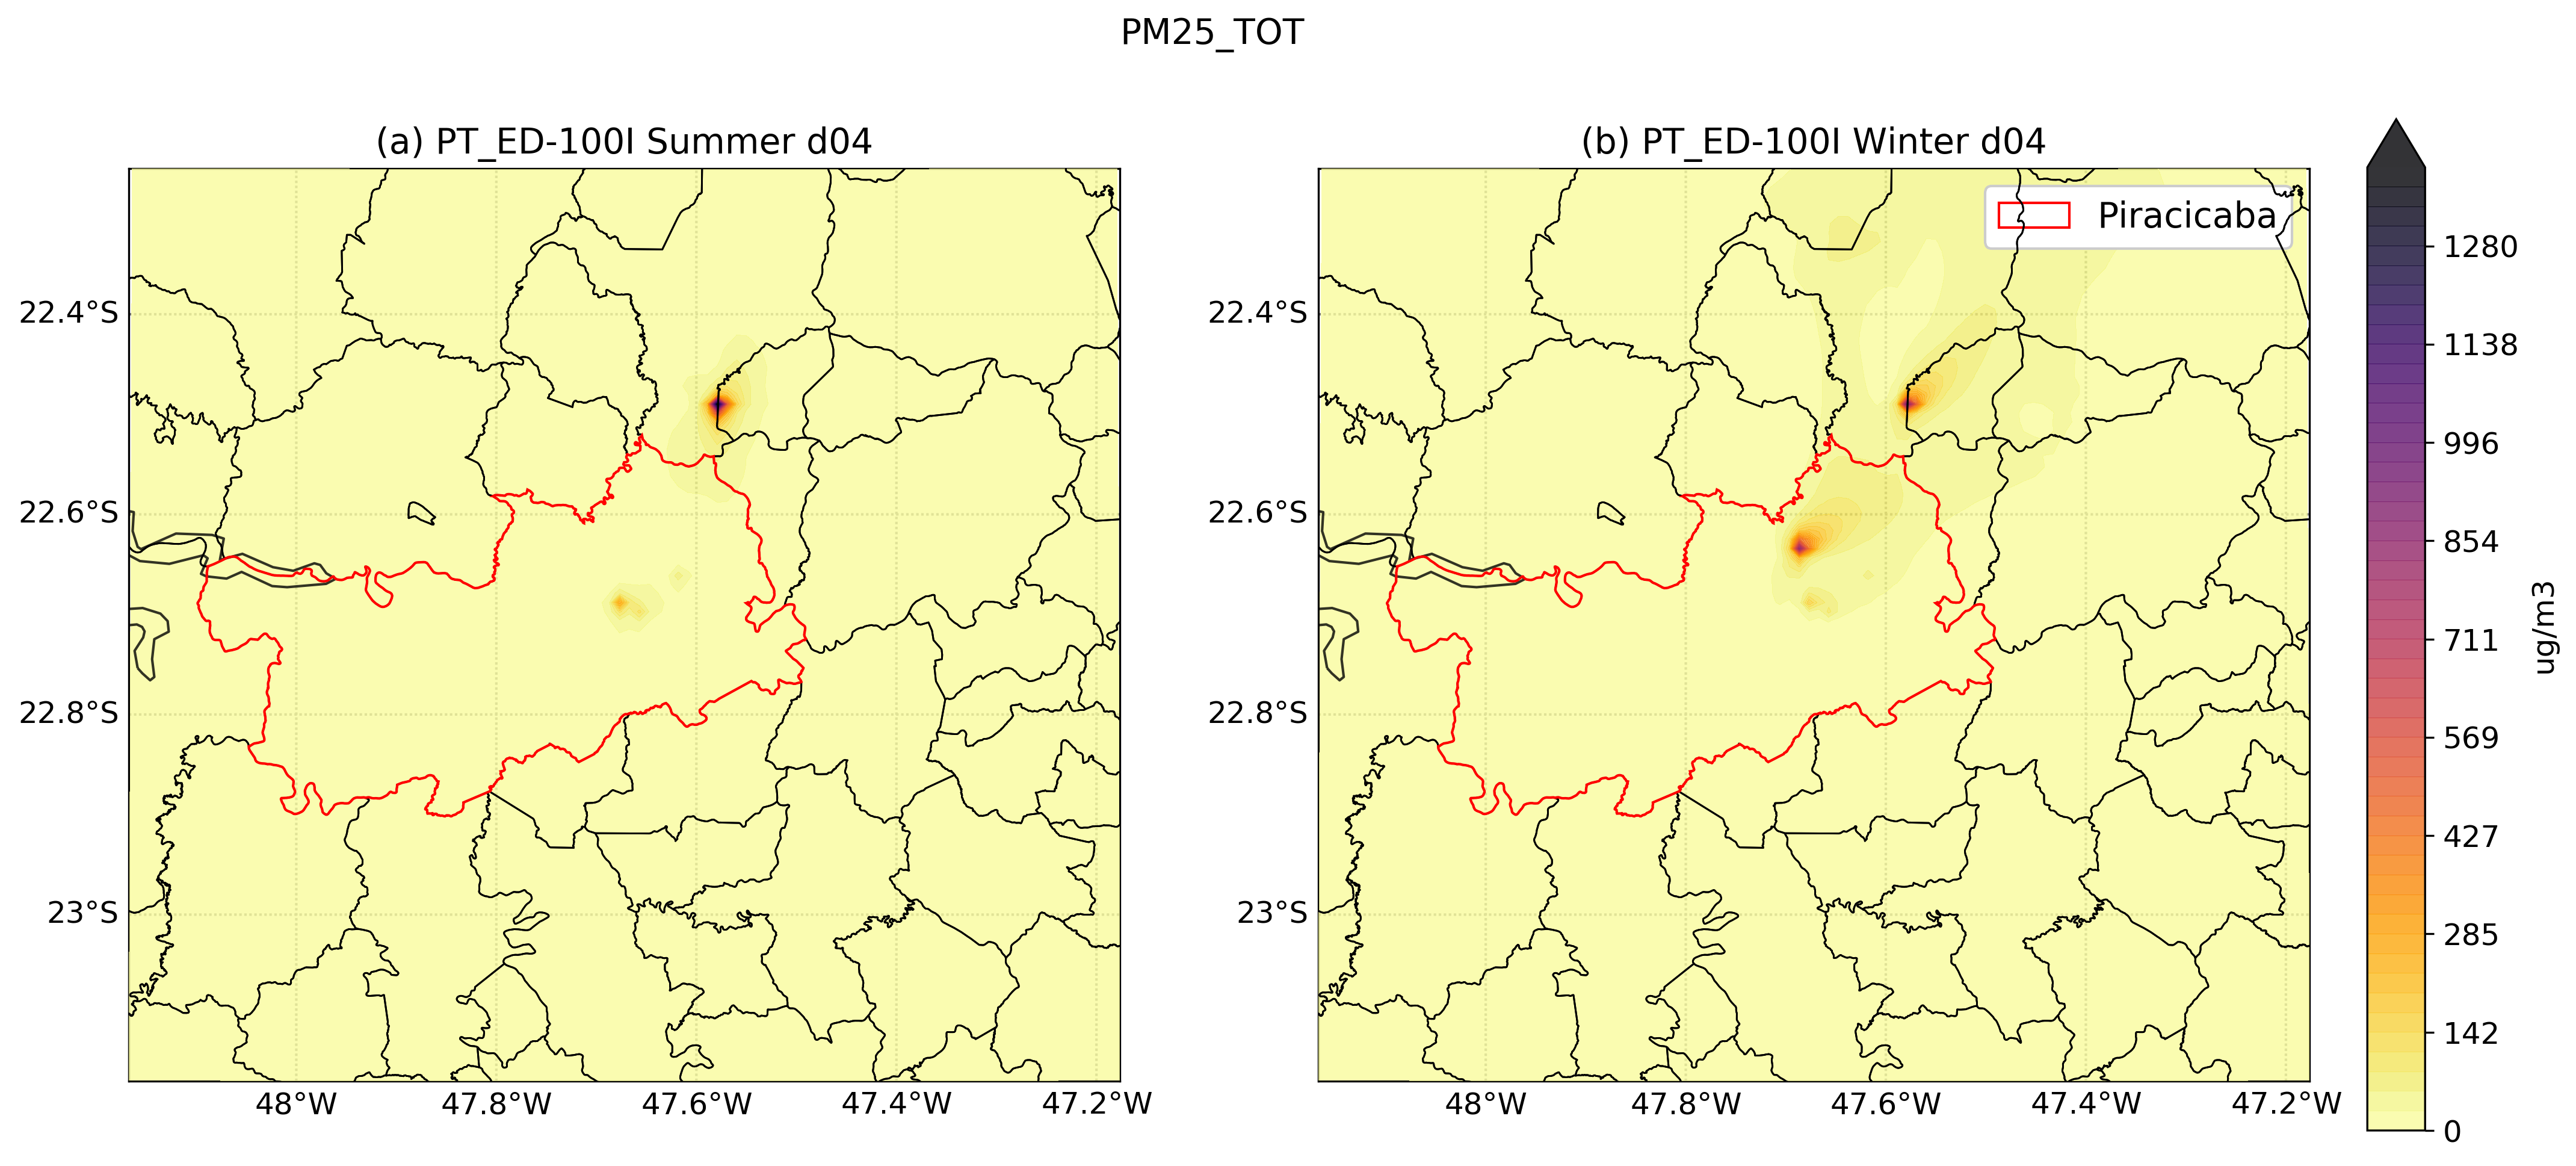

In [9]:
param = 'PM25_TOT'

maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]

aconcsec = aconc[2:4]
persec = per[2:4]
simsec = sim[2:4]

llvl = 0
hlvl = 0
for i in range(0,2):
    if float(aconcsec[i][param].mean(dim='TSTEP').max()) > hlvl:
        hlvl = (float(aconcsec[i][param].mean(dim='TSTEP').max()))
        print (hlvl)
    if float(aconcsec[i][param].mean(dim='TSTEP').min()) < llvl:
        llvl = (float(aconcsec[i][param].mean(dim='TSTEP').min()))

#llvl = (np.ceil(llvl*100))/100
#hlvl = (np.ceil(hlvl*100))/100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7), dpi=300)
fig.suptitle(param, fontsize=14)

for ac, p, ax, s in zip(aconcsec,persec,axes.flat,simsec):  
    print(s)
    d = np.squeeze(ac[param].mean(dim='TSTEP'))
    d = np.ma.array(d,mask=d<0)

    # PLOT COLORMAP
    ax.set_title(s+' '+p+' '+grade[:3], fontsize=14)
    m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=ax)           
    paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.inferno_r,
                        alpha=0.8,
                        vmin=llvl,
                        vmax=hlvl,
                        levels=np.linspace(llvl,hlvl),
                        extend='max',
                        zorder=5)

# ADD FEATURES
    # Draw some map elements on the map
    m.drawcoastlines(linewidth=1.0, color=[0,0,0,0.8], zorder=8)
    m.drawstates(linewidth=1.0, color='k', zorder=8)
    m.drawcountries(linewidth=1.0, color='k', zorder=8)
    #m.bluemarble()
    #m.shadedrelief()
    #m.drawrivers(color='blue')
    m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
    m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
    #m.arcgisimage(service=maps[6], dpi=500, verbose= True)

# ADD SHAPES
    shps = ['Piracicaba']
    colors= {'Piracicaba':'red', 'RMSP':'purple'}
    shapes = {}
#### SHAPE 1
    m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
    p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
    shapes[shps[0]] = p
    
    m.readshapefile(wrfdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color='k', linewidth=0.7, zorder=9)
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
    for shp in shps:
        ax.add_artist(shapes[shp]) 
## END FOR LOOP


# ADJUST PLOT
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8]) #left, bottom, width, height

#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
axes.flat[1].legend(handles=handles, labels=labels, framealpha=1., loc='upper right', fontsize=14)

## COLORBAR
cbar = fig.colorbar(paramplot, cax=cax) # Plot Colorbar
cbar.set_label(aconc[0].variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 12)

plt.show()


In [10]:
## Plotar 4 figuras (ED Verao e Inverno, PT Verao e Inverno)
#per = ['Summer','Winter','Summer','Winter']
#sim = ['(a) '+modnames[0],'(b) '+modnames[0],'(a) '+modptnames[0],'(b) '+modptnames[0]]
for i in range(0,len(aconc)):
    print('MEAN '+sim[i]+' '+per[i]+': '+ str(float(aconc[i][param].mean(dim='TSTEP').mean())))
    print('MAX '+sim[i]+' '+per[i]+': '+ str(float(aconc[i][param].mean(dim='TSTEP').max())))
    print('MIN '+sim[i]+' '+per[i]+': '+ str(float(aconc[i][param].mean(dim='TSTEP').min())))

MEAN (a) ED Summer: 2.7506086826324463
MAX (a) ED Summer: 5.3158464431762695
MIN (a) ED Summer: 1.7692655324935913
MEAN (b) ED Winter: 2.7125561237335205
MAX (b) ED Winter: 4.980375289916992
MIN (b) ED Winter: 1.6936098337173462
MEAN (a) PT_ED-100I Summer: 7.2122697830200195
MAX (a) PT_ED-100I Summer: 1394.1676025390625
MIN (a) PT_ED-100I Summer: 2.0953009128570557
MEAN (b) PT_ED-100I Winter: 11.097065925598145
MAX (b) PT_ED-100I Winter: 920.583984375
MIN (b) PT_ED-100I Winter: 2.041168689727783


(a) ED


D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anacon

(b) ED


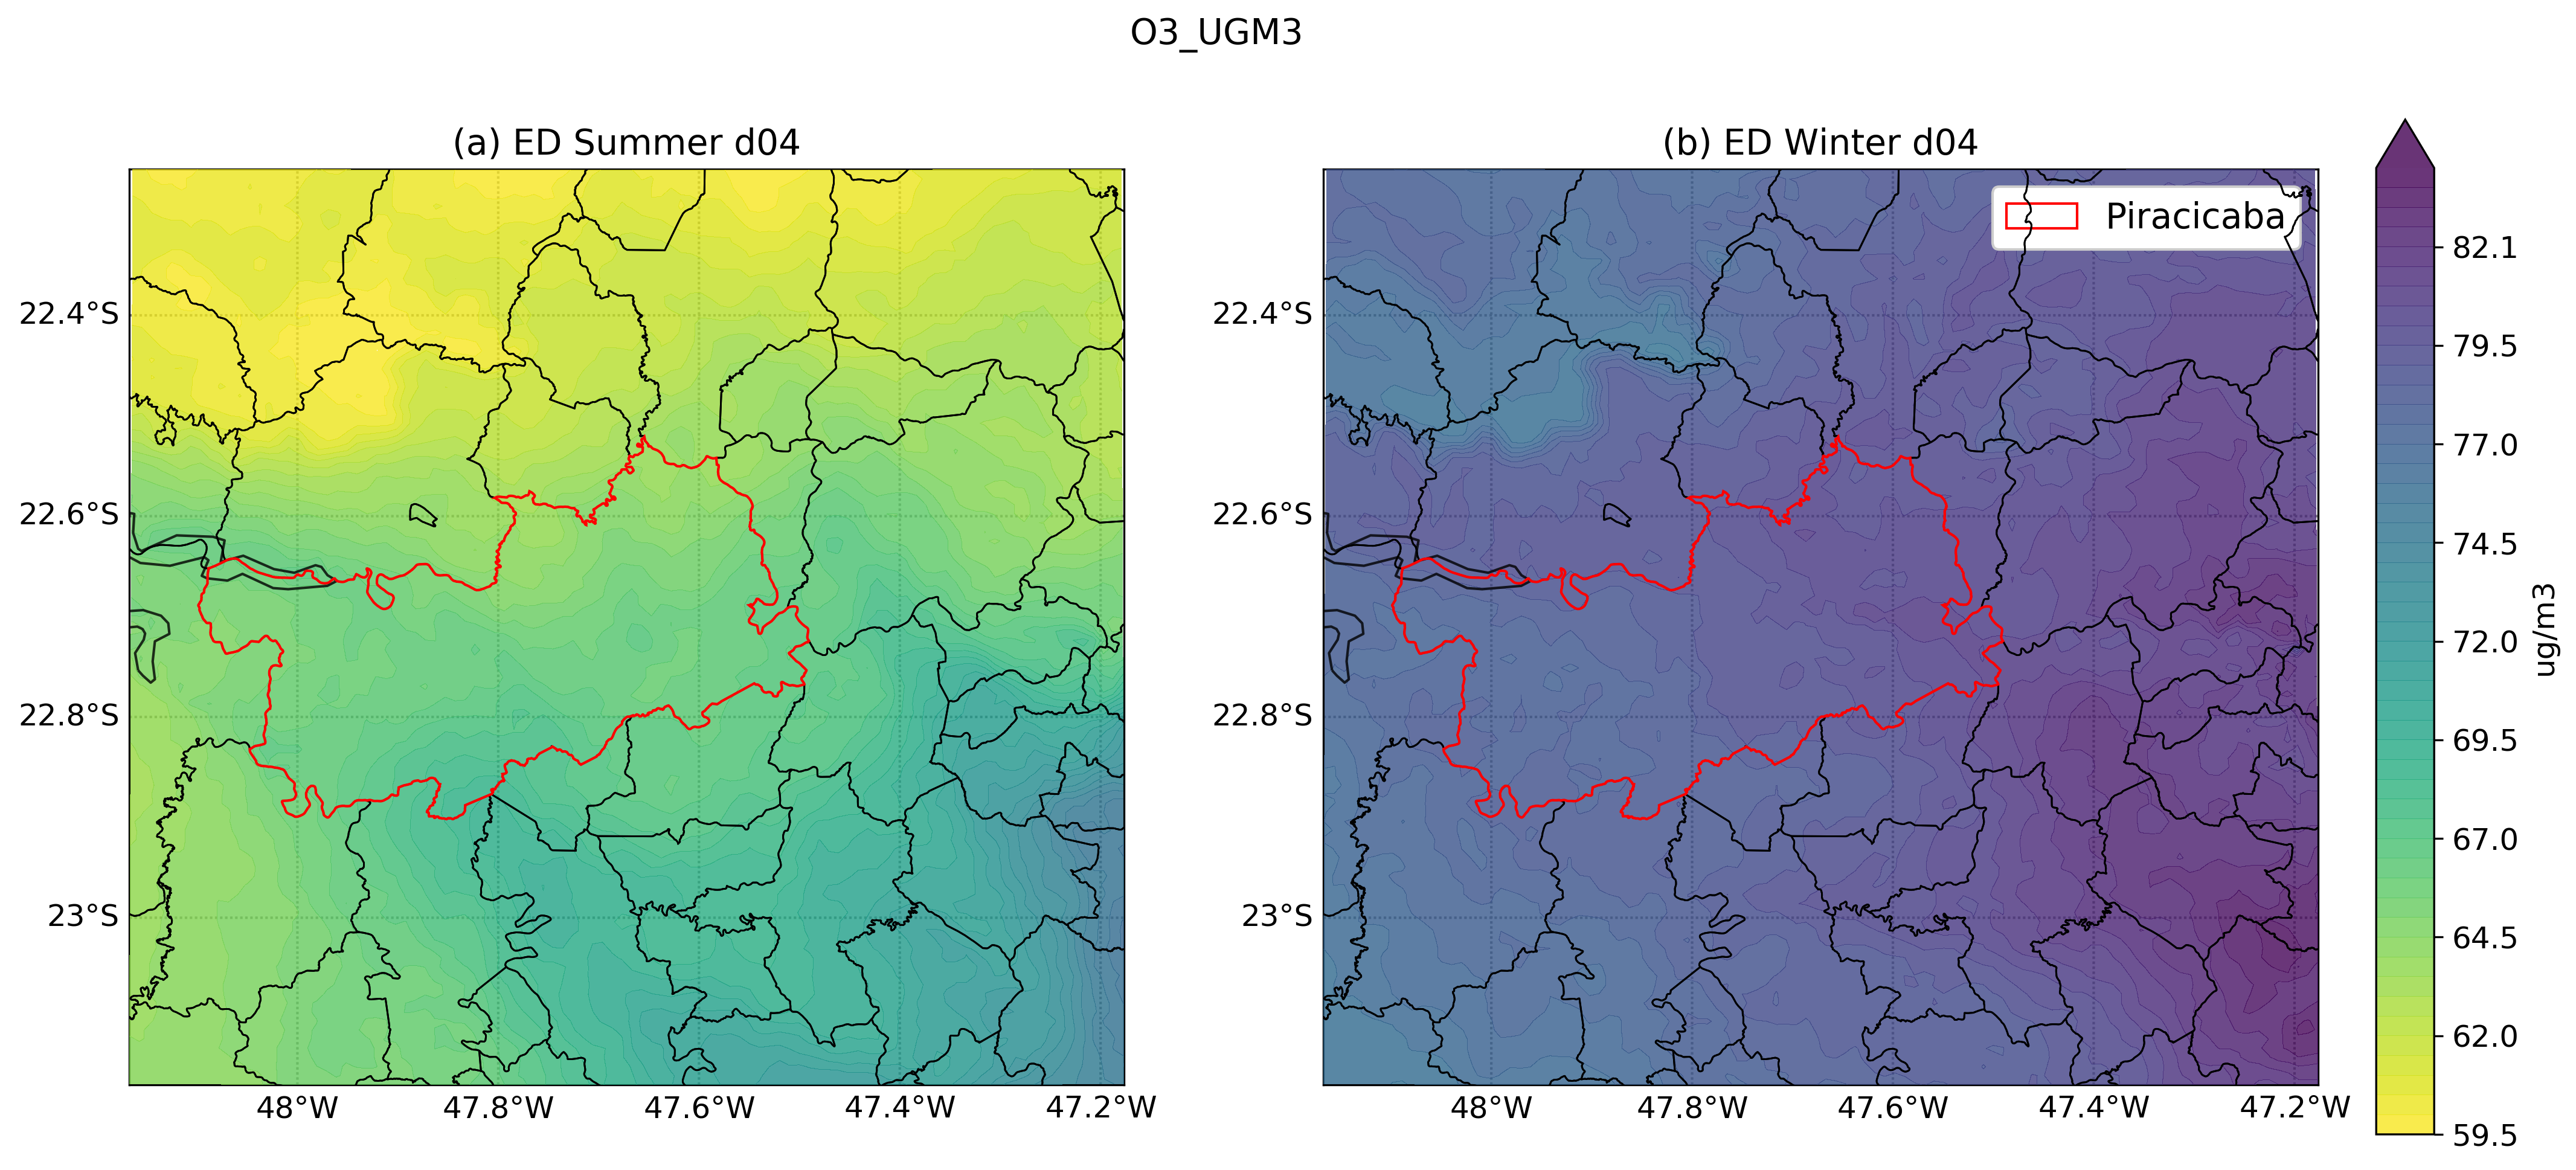

In [18]:
param = 'O3_UGM3'

maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]

aconcsec = aconc[:2]
persec = per[:2]
simsec = sim[:2]

llvl = 80
hlvl = 0
for i in range(0,2):
    if float(aconcsec[i][param].mean(dim='TSTEP').max()) > hlvl:
        hlvl = (float(aconcsec[i][param].mean(dim='TSTEP').max()))
    if float(aconcsec[i][param].mean(dim='TSTEP').min()) < llvl:
        llvl = (float(aconcsec[i][param].mean(dim='TSTEP').min()))

llvl = (np.ceil(llvl*100))/100
hlvl = (np.ceil(hlvl*100))/100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7), dpi=300)
fig.suptitle(param, fontsize=14)

for ac, p, ax, s in zip(aconcsec,persec,axes.flat,simsec):  
    print(s)
    d = np.squeeze(ac[param].mean(dim='TSTEP'))
    d = np.ma.array(d,mask=d<0)

    # PLOT COLORMAP
    ax.set_title(s+' '+p+' '+grade[:3], fontsize=14)
    m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=ax)           
    paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.viridis_r,
                        alpha=0.8,
                        vmin=llvl,
                        vmax=hlvl,
                        levels=np.linspace(llvl,hlvl),
                        extend='max',
                        zorder=5)

# ADD FEATURES
    # Draw some map elements on the map
    m.drawcoastlines(linewidth=1.0, color=[0,0,0,0.8], zorder=8)
    m.drawstates(linewidth=1.0, color='k', zorder=8)
    m.drawcountries(linewidth=1.0, color='k', zorder=8)
    #m.bluemarble()
    #m.shadedrelief()
    #m.drawrivers(color='blue')
    m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
    m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
    #m.arcgisimage(service=maps[6], dpi=500, verbose= True)

# ADD SHAPES
    shps = ['Piracicaba']
    colors= {'Piracicaba':'red', 'RMSP':'purple'}
    shapes = {}
#### SHAPE 1
    m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
    p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
    shapes[shps[0]] = p
    
    m.readshapefile(wrfdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color='k', linewidth=0.7, zorder=9)
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
    for shp in shps:
        ax.add_artist(shapes[shp]) 
## END FOR LOOP


# ADJUST PLOT
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8]) #left, bottom, width, height

#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
axes.flat[1].legend(handles=handles, labels=labels, framealpha=1., loc='upper right', fontsize=14)

## COLORBAR
cbar = fig.colorbar(paramplot, cax=cax, format='%.1f') # Plot Colorbar
cbar.set_label(aconc[0].variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 12)

plt.show()


74.94026184082031
83.583251953125
(a) PT_ED-100I


D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:85: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\Users\50033096\AppData\Local\Continuum\anacon

(b) PT_ED-100I


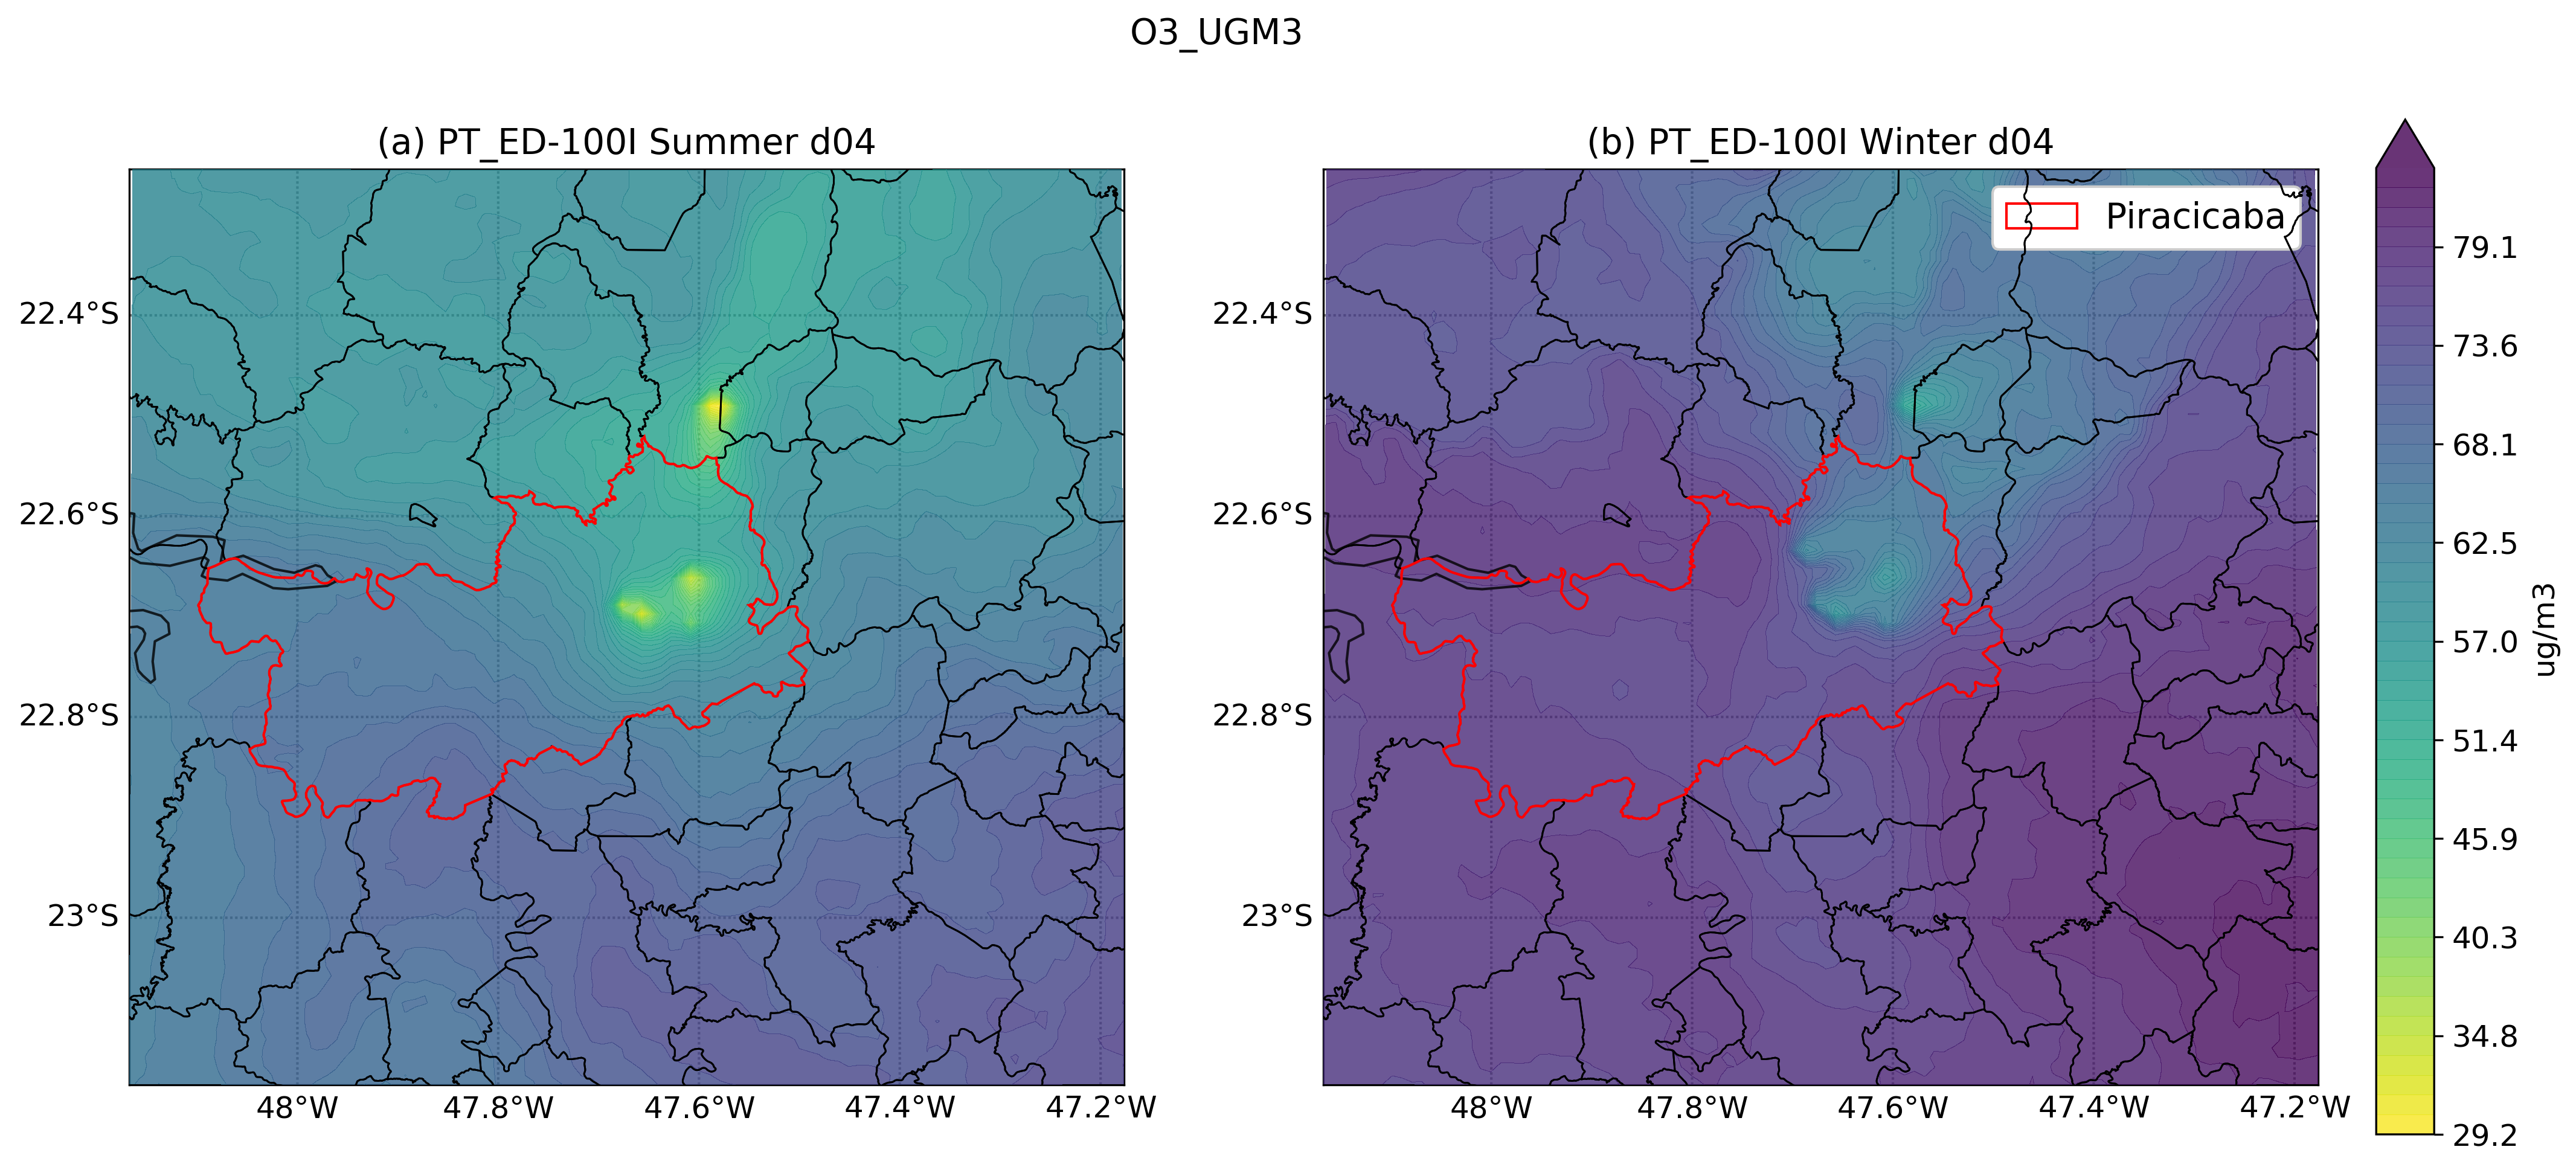

In [19]:
param = 'O3_UGM3'

maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]

aconcsec = aconc[2:4]
persec = per[2:4]
simsec = sim[2:4]

llvl = 80
hlvl = 0
for i in range(0,2):
    if float(aconcsec[i][param].mean(dim='TSTEP').max()) > hlvl:
        hlvl = (float(aconcsec[i][param].mean(dim='TSTEP').max()))
        print (hlvl)
    if float(aconcsec[i][param].mean(dim='TSTEP').min()) < llvl:
        llvl = (float(aconcsec[i][param].mean(dim='TSTEP').min()))

#llvl = (np.ceil(llvl*100))/100
#hlvl = (np.ceil(hlvl*100))/100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7), dpi=300)
fig.suptitle(param, fontsize=14)

for ac, p, ax, s in zip(aconcsec,persec,axes.flat,simsec):  
    print(s)
    d = np.squeeze(ac[param].mean(dim='TSTEP'))
    d = np.ma.array(d,mask=d<0)

    # PLOT COLORMAP
    ax.set_title(s+' '+p+' '+grade[:3], fontsize=14)
    m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=ax)           
    paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.viridis_r,
                        alpha=0.8,
                        vmin=llvl,
                        vmax=hlvl,
                        levels=np.linspace(llvl,hlvl),
                        extend='max',
                        zorder=5)

# ADD FEATURES
    # Draw some map elements on the map
    m.drawcoastlines(linewidth=1.0, color=[0,0,0,0.8], zorder=8)
    m.drawstates(linewidth=1.0, color='k', zorder=8)
    m.drawcountries(linewidth=1.0, color='k', zorder=8)
    #m.bluemarble()
    #m.shadedrelief()
    #m.drawrivers(color='blue')
    m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
    m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
    #m.arcgisimage(service=maps[6], dpi=500, verbose= True)

# ADD SHAPES
    shps = ['Piracicaba']
    colors= {'Piracicaba':'red', 'RMSP':'purple'}
    shapes = {}
#### SHAPE 1
    m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
    p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
    shapes[shps[0]] = p
    
    m.readshapefile(wrfdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color='k', linewidth=0.7, zorder=9)
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
    for shp in shps:
        ax.add_artist(shapes[shp]) 
## END FOR LOOP


# ADJUST PLOT
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8]) #left, bottom, width, height

#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
axes.flat[1].legend(handles=handles, labels=labels, framealpha=1., loc='upper right', fontsize=14)

## COLORBAR
cbar = fig.colorbar(paramplot, cax=cax, format='%.1f') # Plot Colorbar
cbar.set_label(aconc[0].variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 12)

plt.show()


In [20]:
## Plotar 4 figuras (ED Verao e Inverno, PT Verao e Inverno)
#per = ['Summer','Winter','Summer','Winter']
#sim = ['(a) '+modnames[0],'(b) '+modnames[0],'(a) '+modptnames[0],'(b) '+modptnames[0]]
for i in range(0,len(aconc)):
    print('MEAN '+sim[i]+' '+per[i]+': '+ str(float(aconc[i][param].mean(dim='TSTEP').mean())))
    print('MAX '+sim[i]+' '+per[i]+': '+ str(float(aconc[i][param].mean(dim='TSTEP').max())))
    print('MIN '+sim[i]+' '+per[i]+': '+ str(float(aconc[i][param].mean(dim='TSTEP').min())))

MEAN (a) ED Summer: 65.4639892578125
MAX (a) ED Summer: 76.18163299560547
MIN (a) ED Summer: 59.460662841796875
MEAN (b) ED Winter: 79.19825744628906
MAX (b) ED Winter: 84.0544204711914
MIN (b) ED Winter: 75.34918212890625
MEAN (a) PT_ED-100I Summer: 63.62326431274414
MAX (a) PT_ED-100I Summer: 74.94026184082031
MIN (a) PT_ED-100I Summer: 29.24650001525879
MEAN (b) PT_ED-100I Winter: 75.2291259765625
MAX (b) PT_ED-100I Winter: 83.583251953125
MIN (b) PT_ED-100I Winter: 52.05738067626953


### Material Particulado

In [7]:
## Plotar 4 figuras (ED Verao e Inverno, PT Verao e Inverno)
per = ['Verão','Inverno','Verão','Inverno']
sim = [modnames[0],modnames[0],modptnames[0],modptnames[0]]

ED
ED
PT_ED-100I
PT_ED-100I


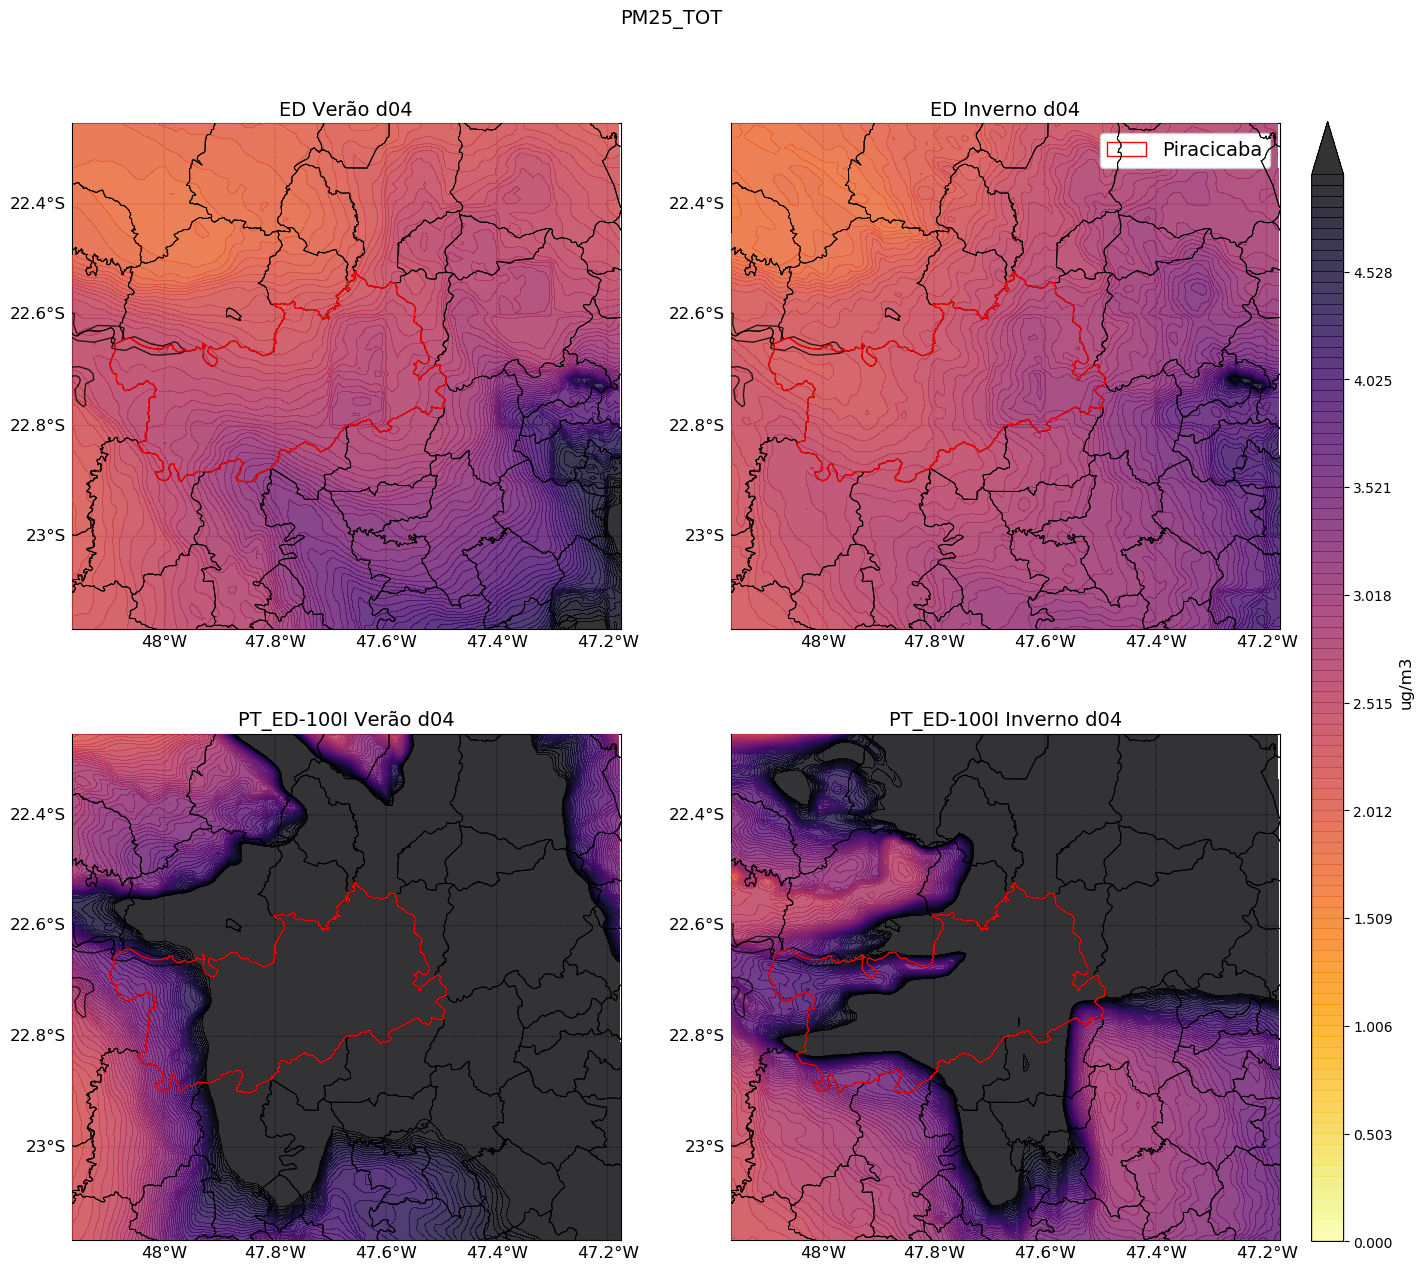

In [35]:
param = 'PM25_TOT'

maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]

llvl = 0
hlvl = 0
for i in range(0,2):
    if float(aconc[i][param].max()) > hlvl:
        hlvl = (float(aconc[i][param].mean(dim='TSTEP').max()))
    if float(aconc[i][param].min()) < llvl:
        llvl = (float(aconc[i][param].mean(dim='TSTEP').min()))
#hlvl = 200

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,14), dpi=100)
fig.suptitle(param, fontsize=14)

for ac, p, ax, s in zip(aconc,per,axes.flat,sim):  
    print(s)
    d = np.squeeze(ac[param].mean(dim='TSTEP'))
    d = np.ma.array(d,mask=d<0)

    # PLOT COLORMAP
    ax.set_title(s+' '+p+' '+grade[:3], fontsize=14)
    m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=ax)           
    paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.inferno_r,
                        alpha=0.8,
                        vmin=llvl,
                        vmax=hlvl,
                        levels=np.linspace(llvl,hlvl,100),
                        extend='max',
                        zorder=5)

# ADD FEATURES
    # Draw some map elements on the map
    m.drawcoastlines(linewidth=1.0, color=[0,0,0,0.8], zorder=8)
    m.drawstates(linewidth=1.0, color='k', zorder=8)
    m.drawcountries(linewidth=1.0, color='k', zorder=8)
    #m.bluemarble()
    #m.shadedrelief()
    #m.drawrivers(color='blue')
    m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
    m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
    #m.arcgisimage(service=maps[6], dpi=500, verbose= True)

# ADD SHAPES
    shps = ['Piracicaba']
    colors= {'Piracicaba':'red', 'RMSP':'purple'}
    shapes = {}
#### SHAPE 1
    m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
    p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
    shapes[shps[0]] = p
    
    m.readshapefile(wrfdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color='k', linewidth=0.7, zorder=9)
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
    for shp in shps:
        ax.add_artist(shapes[shp]) 
## END FOR LOOP


# ADJUST PLOT
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8]) #left, bottom, width, height

#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
axes.flat[1].legend(handles=handles, labels=labels, framealpha=1., loc='upper right', fontsize=14)

## COLORBAR
cbar = fig.colorbar(paramplot, cax=cax) # Plot Colorbar
cbar.set_label(aconc[0].variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 10)

plt.show()


ED
ED
PT_ED-100I
PT_ED-100I


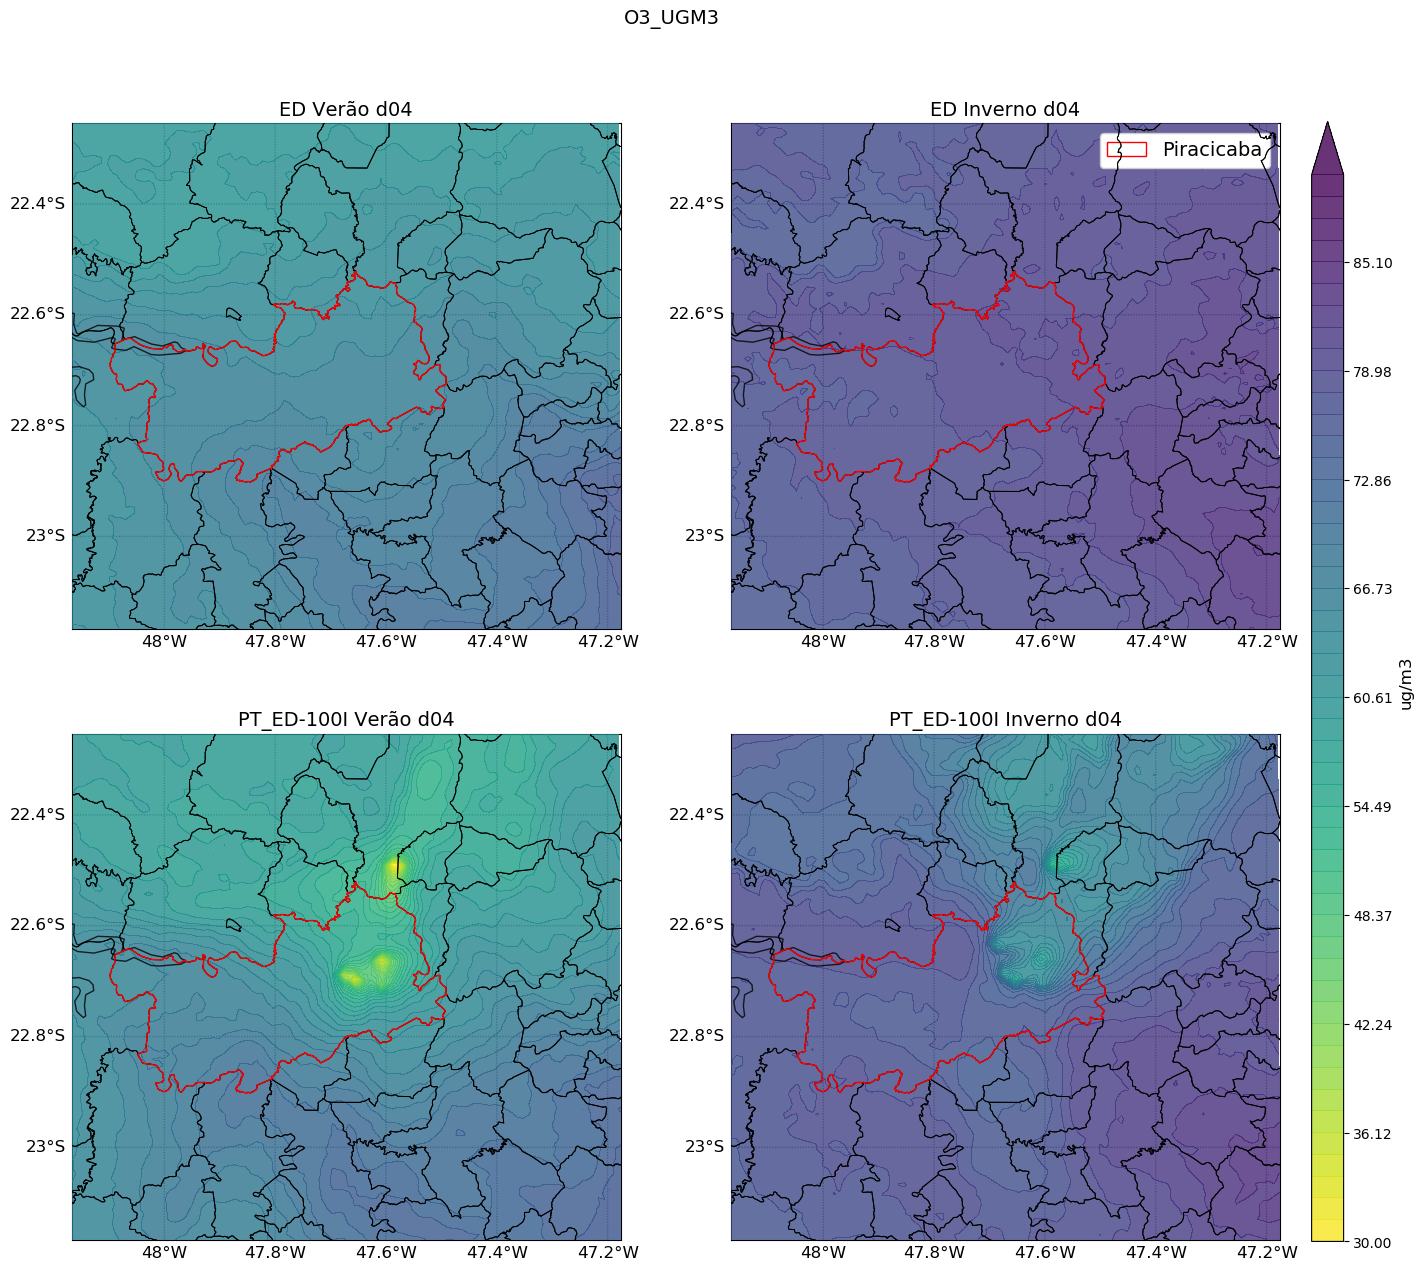

In [36]:
param = 'O3_UGM3'

maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]

llvl = 20
hlvl = 100
for i in range(0,4):
    if float(aconc[i][param].max()) > hlvl:
        hlvl = (float(aconc[i][param].mean(dim='TSTEP').max()))
    if float(aconc[i][param].min()) < llvl:
        llvl = (float(aconc[i][param].mean(dim='TSTEP').min()))
llvl = 30
hlvl = 90    
        
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,14), dpi=100)
fig.suptitle(param, fontsize=14)

for ac, p, ax, s in zip(aconc,per,axes.flat,sim):  
    print(s)
    d = np.squeeze(ac[param])[:,:,:].mean(dim='TSTEP')
    d = np.ma.array(d,mask=d<0)

    # PLOT COLORMAP
    ax.set_title(s+' '+p+' '+grade[:3], fontsize=14)
    m = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=ax)           
    paramplot = m.contourf(x=longs,       #X specify the (x) coordinates of the surface
                        y=lats,                 #Y specify the (y) coordinates of the surface
                        data=d, 
                        antialiased = False,
                        cmap=plt.cm.viridis_r,
                        alpha=0.8,
                        vmin=llvl,
                        vmax=hlvl,
                        levels=np.linspace(llvl,hlvl,50),
                        extend='max',
                        zorder=5)

# ADD FEATURES
    # Draw some map elements on the map
    m.drawcoastlines(linewidth=1.0, color=[0,0,0,0.8], zorder=8)
    m.drawstates(linewidth=1.0, color='k', zorder=8)
    m.drawcountries(linewidth=1.0, color='k', zorder=8)
    #.bluemarble()
    #m.shadedrelief()
    #m.drawrivers(color='blue')
    m.drawparallels(np.arange(-80., 81., 0.2), color='grey', labels=[1,0,0,0], fontsize=12)       
    m.drawmeridians(np.arange(-180., 181., 0.2), color='grey', labels=[0,0,0,1], fontsize=12)

## MAP ARCGIS
    #m.arcgisimage(service=maps[6], dpi=500, verbose= True)

# ADD SHAPES
    shps = ['Piracicaba']
    colors= {'Piracicaba':'red', 'RMSP':'purple'}
    shapes = {}
#### SHAPE 1
    m.readshapefile(wrfdir+'arqShape/pirashape', 'Piracicaba', drawbounds = False, color='r', linewidth=1.0)
    p = Polygon(np.array(m.Piracicaba)[0,:,:], True, facecolor='none', edgecolor=colors[shps[0]], alpha=1.0, zorder=10)
    shapes[shps[0]] = p
    
    m.readshapefile(wrfdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color='k', linewidth=0.7, zorder=9)
#### SHAPE 2
#m.readshapefile(wrfdir+'arqShape/RMSP_3', 'RMSP', drawbounds = False, color='r', linewidth=1.0)
#p = Polygon(np.array(m.RMSP[13]), True, facecolor='none', edgecolor=colors[shps[1]], alpha=1.0, zorder=10)
#shapes[shps[1]] = p
#-------- shape names and legend
    for shp in shps:
        ax.add_artist(shapes[shp]) 
## END FOR LOOP


# ADJUST PLOT
plt.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = plt.axes([0.9, 0.1, 0.02, 0.8]) #left, bottom, width, height

#-------- create legend, by first getting the already present handles, labels
handles, labels = plt.gca().get_legend_handles_labels()
#-------- and then adding the new ones
handles.extend([shapes[shp] for shp in shps])  
labels.extend(shps)                     
axes.flat[1].legend(handles=handles, labels=labels, framealpha=1., loc='upper right', fontsize=14)

## COLORBAR
cbar = fig.colorbar(paramplot, cax=cax, boundaries=(0,84)) # Plot Colorbar
cbar.set_label(aconc[0].variables[param].attrs['units'], fontsize = 12, rotation=90)
cbar.ax.tick_params(labelsize = 10)

plt.show()

In [21]:
mes

['jan', 'jul']

In [20]:
testencf = Dataset((directory+ms+'.'+grade+moded[0]+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                                    mes[0]+'_'+data[0]+'.nc')))

SyntaxError: invalid syntax (<ipython-input-20-e5866ca17ac2>, line 2)